In [1]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt

In [2]:
## set working directory
os.chdir("/data1/niehu/ibd_public_data_20210821/analysis_20220111/02.integrate/T_NK/")

In [3]:
## read data
adata = sc.read_h5ad("./T_NK.bySample.n10.bbknn_umap_leiden_marker.res1.5.h5ad")
adata = sc.pp.subsample(adata, fraction=1, copy=True)

In [4]:
## add meta data
meta_data = pd.read_csv("/home/niehu/niehu/ibd_public_data_20210821/analysis_20220111/01.preprocess/cell_meta/ibd_meta_data_cells.csv", header=0)
meta_data.index = meta_data.cellName

select = meta_data[meta_data.index.isin(adata.obs.index.to_list())]
select = select.loc[adata.obs.index,:]

adata.obs["location2"] = pd.Categorical(select.location2)
adata.obs["location1"] = pd.Categorical(select.location1)
adata.obs["developmentStage"] = pd.Categorical(select.developmentStage)

/home/niehu/niehu/soft/anaconda3/envs/jupyterlab/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3012: DtypeWarning: Columns (3,4,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


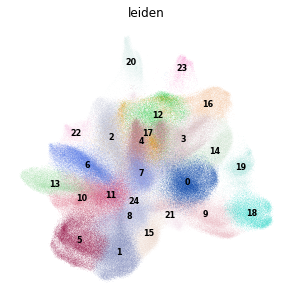

In [19]:
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adata, color='leiden', legend_loc='on data', title='leiden', frameon=False, legend_fontsize = 8, save=".png")

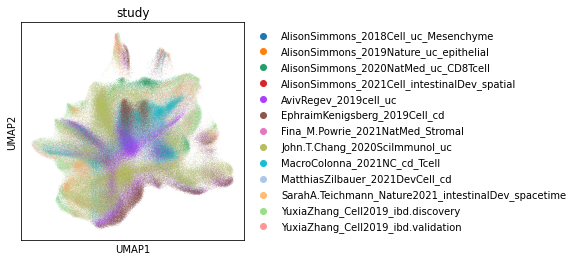

In [6]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color=["study"])

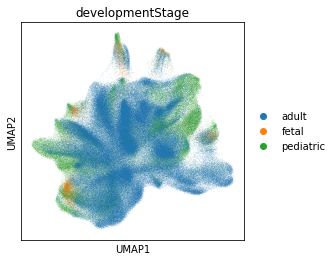

In [7]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color=["developmentStage"])

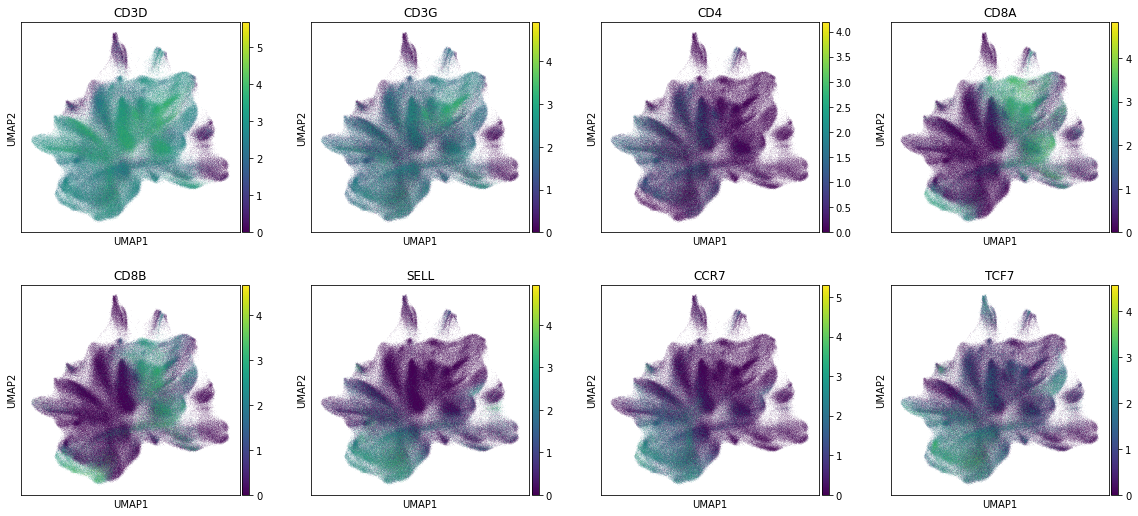

In [8]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color=["CD3D","CD3G","CD4","CD8A","CD8B","SELL","CCR7","TCF7"])

In [9]:
import celltypist
from celltypist import models

In [10]:
predictions = celltypist.annotate(adata, model = 'Immune_All_Low.pkl', majority_voting = True, over_clustering = 'leiden')

👀 Detected scaled expression in the input data, will try the `.raw` attribute
🔬 Input data has 450361 cells and 15813 genes
🔗 Matching reference genes in the model
🧬 1934 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🗳️ Majority voting the predictions
✅ Majority voting done!


In [11]:
adata = predictions.to_adata()

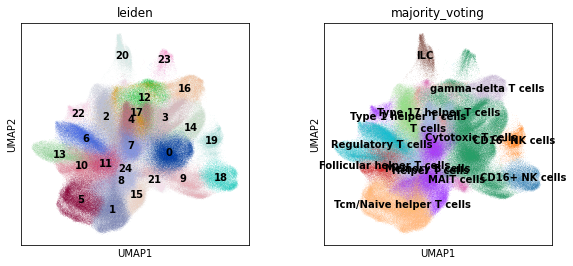

In [12]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color = ['leiden', 'majority_voting'], legend_loc = 'on data')

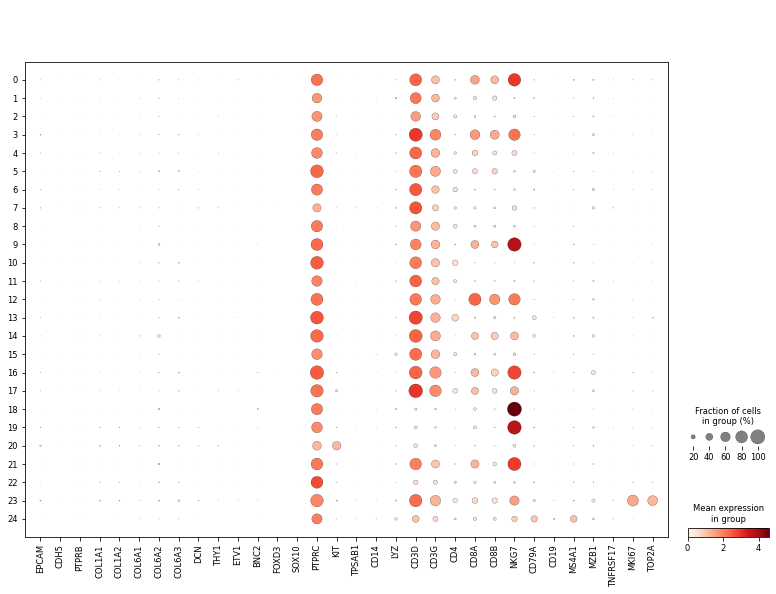

In [13]:
major_markers = ["EPCAM", # epithelial
                 "CDH5","PTPRB",  # endothelial
                 "COL1A1","COL1A2","COL6A1","COL6A2","COL6A3","DCN","THY1", ## Mesenchymal
                 "ETV1","BNC2","FOXD3","SOX10",  # neuronal
                 "PTPRC", # immune cells
                 "KIT","TPSAB1", # mast cells
                 "CD14","LYZ", # myeloid
                 "CD3D","CD3G","CD4","CD8A","CD8B","NKG7", # T/NK cells
                 "CD79A","CD19","MS4A1","MZB1","TNFRSF17", # B/plasmal cells
                 "MKI67","TOP2A"
                 ]
sc.pl.dotplot(adata, major_markers, groupby='leiden');

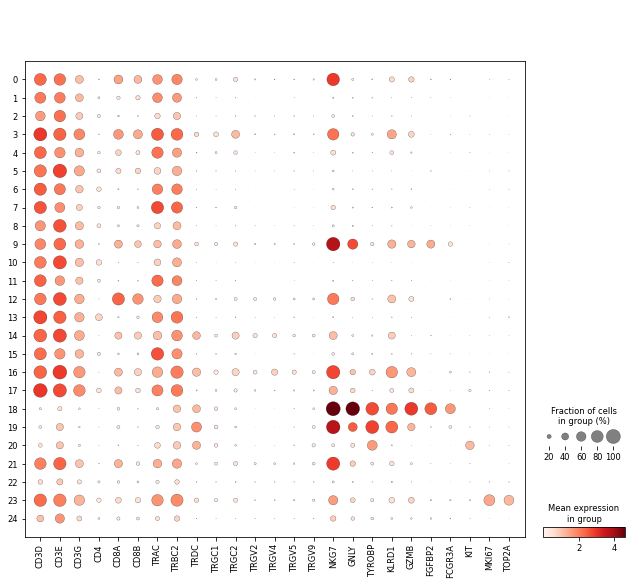

In [14]:
sc.pl.dotplot(adata, ["CD3D","CD3E","CD3G","CD4","CD8A","CD8B",
                      "TRAC","TRBC2","TRDC","TRGC1","TRGC2","TRGV2","TRGV4","TRGV5","TRGV9",
                      "NKG7","GNLY","TYROBP","KLRD1", ## NK
                      "GZMB","FGFBP2","FCGR3A", ## NKT
                      "KIT",## ILC
                      "MKI67","TOP2A",
                     ], groupby='leiden')
## C18 => NK
## C19 => NK
## C20 => ILC
## C23 => Cycling

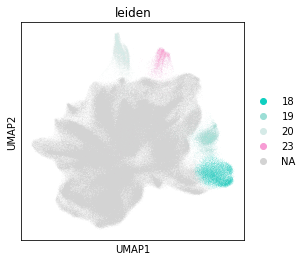

In [15]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color='leiden', groups=['18','19','20','23'])

In [20]:
NK_cells = adata.obs[ adata.obs.leiden.isin(['18','19'])].index.to_list()
ILC_cells = adata.obs[ adata.obs.leiden == '20'].index.to_list()
Cycling_cells = adata.obs[ adata.obs.leiden == '23'].index.to_list()

In [21]:
others = adata[ np.logical_not(adata.obs.leiden.isin(['18','19','20','23'])) ]

In [22]:
cells = others.obs.index

In [23]:
tmp = sc.read_h5ad("../ibd_20220111.raw.h5ad")

In [24]:
NK = tmp[tmp.obs.index.isin(NK_cells)]
ILC = tmp[tmp.obs.index.isin(ILC_cells)]
CyclingT = tmp[tmp.obs.index.isin(Cycling_cells)]

NK.write_h5ad("NK_V2.h5ad")
ILC.write_h5ad("ILC_V2.h5ad")
CyclingT.write_h5ad("CyclingT_V2.h5ad")

In [25]:
T_adata = tmp[tmp.obs.index.isin(cells)]

In [26]:
T_adata

View of AnnData object with n_obs × n_vars = 419187 × 16105
    obs: 'sampleName', 'study', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_rp', 'pct_counts_rp', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'rp', 'exclude', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [27]:
CD8A = T_adata[:,"CD8A"].X.toarray()
CD8B = T_adata[:,"CD8B"].X.toarray()
CD4 = T_adata[:,"CD4"].X.toarray()

TRGV2 = T_adata[:,"TRGV2"].X.toarray()
TRGV4 = T_adata[:,"TRGV4"].X.toarray()
TRGV5 = T_adata[:,"TRGV5"].X.toarray()
TRGV9 = T_adata[:,"TRGV9"].X.toarray()

CD79A = T_adata[:,"CD79A"].X.toarray()
MS4A1 = T_adata[:,"MS4A1"].X.toarray()
MZB1 = T_adata[:,"MZB1"].X.toarray()

In [28]:
total = np.array(T_adata.X.sum(axis=1))
CD8A_exp = np.log2( CD8A*10000/total + 1)
CD8B_exp = np.log2( CD8B*10000/total + 1)
CD8_exp = (CD8A_exp + CD8B_exp)/2
CD4_exp = np.log2( CD4*10000/total + 1)

TRGV2_exp = np.log2( TRGV2*10000/total + 1)
TRGV4_exp = np.log2( TRGV4*10000/total + 1)
TRGV5_exp = np.log2( TRGV5*10000/total + 1)
TRGV9_exp = np.log2( TRGV9*10000/total + 1)
TRGV_exp = (TRGV2_exp + TRGV4_exp + TRGV5_exp + TRGV9_exp)/4

CD79A_exp = np.log2( CD79A*10000/total + 1)
MS4A1_exp = np.log2( MS4A1*10000/total + 1)
MZB1_exp = np.log2( MZB1*10000/total + 1)

In [ ]:
#fig=plt.figure(figsize=(6,6))
#plt.scatter(x=CD8A_exp, y=CD8B_exp, alpha = 0.5, s = 0.5)
#plt.xlabel("Relative expression of CD8A")
#plt.ylabel("Relative expression of CD8B")
## a strange plot

In [ ]:
#fig=plt.figure(figsize=(6,6))
#plt.scatter(x=CD4_exp, y=CD8_exp, alpha = 0.5, s = 0.5)
#plt.xlabel("Relative expression of CD4")
#plt.ylabel("Relative expression of CD8")

In [29]:
# T cells
select_clean = np.logical_and(CD79A_exp < 0.1, MS4A1_exp < 0.1)
select_clean = np.logical_and(select_clean, MZB1_exp < 0.1)
print(sum(select_clean))
print(sum(select_clean)/len(T_adata.obs.index))

[380128]
[0.90682201]


In [30]:
## putative gd-T cells
select = np.logical_and(TRGV_exp > 1, CD8_exp < 0.1)
select = np.logical_and(select, CD4_exp < 0.1)
select = np.logical_and(select, select_clean)
gdT = T_adata[select]
print(len(gdT.obs.index))
print(len(gdT.obs.index)/len(tmp.obs.index))
gdT.write_h5ad("gdT_V2.h5ad")

3076
0.002232716408723563


In [31]:
## all abT cells
select = np.logical_not(T_adata.obs.index.isin(gdT.obs.index.to_list())) 
select = select.T.reshape(len(select), 1)
select = np.logical_and(select, select_clean)
print( sum(select) )
print(sum(select)/len(T_adata.obs.index))
abT_pos = T_adata[select]

[377052]
[0.899484]


In [32]:
## putative CD8+ T cells
select = np.logical_and( CD8_exp > 1, CD4_exp < 0.1)
select = np.logical_and(select, select_clean)
CD8_pos = T_adata[select]
print(len(CD8_pos.obs.index))
print(len(CD8_pos.obs.index)/len(T_adata.obs.index))
CD8_pos.write_h5ad("CD8_putative_pos_V2.h5ad")

112309
0.2679209994584756


In [33]:
## putative CD4+ T cells
select = np.logical_and( CD4_exp > 1, CD8_exp < 0.1)
select = np.logical_and(select, select_clean)
CD4_pos = T_adata[select]
print(len(CD4_pos.obs.index))
print(len(CD4_pos.obs.index)/len(T_adata.obs.index))
CD4_pos.write_h5ad("CD4_putative_pos_V2.h5ad")

40192
0.09588083599920799


In [34]:
## all abT cells excluded putative CD4+ and putative CD8+ T cells
CD4_pos_cells = CD4_pos.obs.index.to_list()
CD8_pos_cells = CD8_pos.obs.index.to_list()
known_abT_pos_cells = CD4_pos_cells + CD8_pos_cells
select = np.logical_not( abT_pos.obs.index.isin(known_abT_pos_cells) )
select = select.T.reshape(len(select), 1)
print( sum(select) )
print(sum(select)/len(T_adata.obs.index))
unknown_abT_pos = abT_pos[select]
unknown_abT_pos.write_h5ad("putative_unknown_abT_pos_V2.h5ad")

[224551]
[0.53568217]


In [35]:
## assign adata
gdT_pos_cells = gdT.obs.index.to_list()
CD4_pos_cells = CD4_pos.obs.index.to_list()
CD8_pos_cells = CD8_pos.obs.index.to_list()
unknown_abT_pos_cells = unknown_abT_pos.obs.index.to_list()
NK_cells =adata.obs[adata.obs.leiden.isin(['18','19'])].index.to_list()
ILC_cells =adata.obs[adata.obs.leiden.isin(['20'])].index.to_list()
CyclingT_cells =adata.obs[adata.obs.leiden.isin(['23'])].index.to_list()

In [36]:
adata.obs["mark"] = "T/NK"
adata.obs.loc[adata.obs.index.isin(gdT_pos_cells),"mark"] = "dgT"
adata.obs.loc[adata.obs.index.isin(CD4_pos_cells),"mark"] = "CD4"
adata.obs.loc[adata.obs.index.isin(CD8_pos_cells),"mark"] = "CD8"
adata.obs.loc[adata.obs.index.isin(unknown_abT_pos_cells),"mark"] = "unknown_abT"
adata.obs.loc[adata.obs.index.isin(NK_cells),"mark"] = "NK"
adata.obs.loc[adata.obs.index.isin(ILC_cells),"mark"] = "ILC"

In [37]:
adata.obs.mark.value_counts()/len(adata.obs)

unknown_abT    0.498602
CD8            0.249376
T/NK           0.094602
CD4            0.089244
NK             0.044369
ILC            0.016977
dgT            0.006830
Name: mark, dtype: float64

In [32]:
## test XGboost, decision tree

In [38]:
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [39]:
known_abT_pos = adata[adata.obs.index.isin(known_abT_pos_cells)]
## delete CD4, CD8A and CD8B
known_abT_pos = known_abT_pos[:,np.logical_not(known_abT_pos.var.index.isin(["CD4","CD8A","CD8B"]))]
X = known_abT_pos.X
Y = known_abT_pos.obs.mark.to_list()

In [40]:
## train
model = XGBClassifier()
kfold = StratifiedKFold(n_splits=5)
results = cross_val_score(model, X, Y, cv=kfold, n_jobs = 10)

In [41]:
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 93.23% (0.13%)


In [42]:
model.fit(X, Y)

[21:02:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=96,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

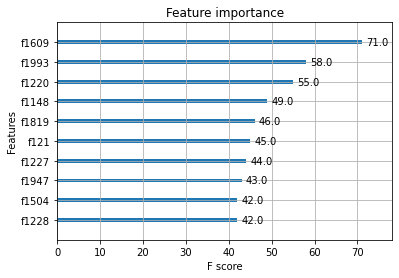

In [43]:
plot_importance(model, max_num_features = 10)
plt.show()

In [51]:
print(known_abT_pos.var_names[1609])
print(known_abT_pos.var_names[1993])
print(known_abT_pos.var_names[1824])
print(known_abT_pos.var_names[118])
print(known_abT_pos.var_names[1219])
print(known_abT_pos.var_names[1948])
print(known_abT_pos.var_names[1509])
print(known_abT_pos.var_names[1226])
print(known_abT_pos.var_names[1227])
print(known_abT_pos.var_names[1146])

CCL5
CD40LG
ZNF347
S100A11
LINC00987
GPM6B
LITAF
GABARAPL1
KLRD1
SLC25A45


In [44]:
## predict
test = adata[adata.obs.index.isin(unknown_abT_pos_cells)]
test = test[:,np.logical_not(test.var.index.isin(["CD4","CD8A","CD8B"]))]

In [45]:
pred = model.predict(test.X)

In [46]:
pd.Series(pred).value_counts()

CD4    149032
CD8     75519
dtype: int64

In [47]:
predicted_CD4 = pred == "CD4"
predicted_CD8 = pred == "CD8"

In [48]:
unknown = adata[adata.obs.index.isin(unknown_abT_pos_cells)]
predicted_CD4_cells = unknown[predicted_CD4].obs.index.to_list()
predicted_CD8_cells = unknown[predicted_CD8].obs.index.to_list()

In [49]:
predicted_CD4_adata = tmp[tmp.obs.index.isin(predicted_CD4_cells)]
predicted_CD4_adata.write_h5ad("predicted_CD4_V2.h5ad")
predicted_CD4_adata

View of AnnData object with n_obs × n_vars = 149032 × 16105
    obs: 'sampleName', 'study', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_rp', 'pct_counts_rp', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'rp', 'exclude', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [50]:
predicted_CD8_adata = tmp[tmp.obs.index.isin(predicted_CD8_cells)]
predicted_CD8_adata.write_h5ad("predicted_CD8_V2.h5ad")
predicted_CD8_adata

View of AnnData object with n_obs × n_vars = 75519 × 16105
    obs: 'sampleName', 'study', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_rp', 'pct_counts_rp', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'rp', 'exclude', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [47]:
## done

In [48]:
## combine data

In [52]:
CD4_pos

View of AnnData object with n_obs × n_vars = 40192 × 16105
    obs: 'sampleName', 'study', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_rp', 'pct_counts_rp', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'rp', 'exclude', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [53]:
CD8_pos

View of AnnData object with n_obs × n_vars = 112309 × 16105
    obs: 'sampleName', 'study', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_rp', 'pct_counts_rp', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'rp', 'exclude', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [54]:
predicted_CD4_adata

View of AnnData object with n_obs × n_vars = 149032 × 16105
    obs: 'sampleName', 'study', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_rp', 'pct_counts_rp', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'rp', 'exclude', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [55]:
predicted_CD8_adata

View of AnnData object with n_obs × n_vars = 75519 × 16105
    obs: 'sampleName', 'study', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_rp', 'pct_counts_rp', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'rp', 'exclude', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [57]:
CD4_all = CD4_pos.concatenate(predicted_CD4_adata, index_unique = None)

In [58]:
CD4_all

AnnData object with n_obs × n_vars = 189224 × 16105
    obs: 'sampleName', 'study', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_rp', 'pct_counts_rp', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'rp', 'exclude', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [59]:
CD8_all = CD8_pos.concatenate(predicted_CD8_adata, index_unique = None)

In [60]:
CD8_all

AnnData object with n_obs × n_vars = 187828 × 16105
    obs: 'sampleName', 'study', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_rp', 'pct_counts_rp', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'rp', 'exclude', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [61]:
CD4_all.write_h5ad("all_CD4_V2.h5ad")

... storing 'sampleName' as categorical


In [62]:
CD8_all.write_h5ad("all_CD8_V2.h5ad")

... storing 'sampleName' as categorical


[20:55:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/niehu/niehu/soft/anaconda3/envs/jupyterlab/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:55:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/niehu/niehu/soft/anaconda3/envs/jupyterlab/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:55:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/niehu/niehu/soft/anaconda3/envs/jupyterlab/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:56:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/niehu/niehu/soft/anaconda3/envs/jupyterlab/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/niehu/niehu/soft/anaconda3/envs/jupyterlab/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:56:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [60]:
## done